##### Кузьмичев Александр Николаевич
##### М8О-406Б-18

<h1><center> Перцептрон Розенблата </center></h1>

<center><h2> Вариант №12 </h2></center>

Структура *Перцептрона Розенблата*. Мы будем строить слой из таких перцептронов в зависимости от того, на сколько классов надо разбить данные. По условию - выход перцептрона $net$, поэтому из схемы ниже нужно изключить пороговую функцию активации.

<img src="https://www.machinelearningmastery.ru/img/0-675619-991897.png">

### Алгоритм обучения

Если дана $(X, Y)$ - обучающая выборка, то задача - найти веса и смещение $(W, b)$ для каждого парцептрона из слоя. 
Алгоритм работает за заданное $N$ количество шагов, или пока веса не перестанут меняться.

1. Инициализация весов и смещения случайным образом. Номер шага $k = 0$.


2. Пока веса изменяются и $k < N$:
    - Для каждого поданного на вход значения $p_i \in X, \; \forall i: 0 \leq i < |X|$:
    
        * Если: $y_i (p_i \cdot W + b) < 0$, cчитаем ошибку $e = y_i - (p_i \cdot W + b)$ меняем веса:
        
        $$W = W + e*p_i$$
        $$b = b +e$$
        
        
3. Полученные  веса и смещения - результат обучения.

### Реализация сети

При обучении добавим к тренировочным данным еденичный столбец для смещения.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class RosenblattLayer:
    def __init__(self, steps = 50, early_stop = False):
        self.steps = steps
        self.w = None
        self.negative_is_zero = False
        self.early_stop = early_stop
    
    def fit(self, X, y):
        # add column for bias and transpose data for comphort operations:
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        y_t = np.array(y.T)
        
        if (y_t == 0).sum():
            self.negative_is_zero = True
            y_t[y_t == 0] = -1

        #init weights
        if self.w is None:
            self.w = np.random.random((X_t.shape[1], y_t.shape[1]))
        
        # main loop
        
        for step in tqdm(range(self.steps)):
            stop = True
            for i in range(X_t.shape[0]):
                # compute error of all perceptrons
                predict = X_t[i].dot(self.w)
                if np.sum(predict*y_t[i] < 0):
                    stop = False
                    e = y_t[i] - X_t[i].dot(self.w)
                    e[predict*y_t[i] >= 0] = 0.0
                    self.w += X_t[i].reshape(X_t.shape[1], 1).dot(e.reshape(1, y_t.shape[1]))
            if stop and self.early_stop:
                break
                
        return self
    
    def set_steps(self, steps):
        self.steps = steps
        
    def set_early_stop(self, stop):
        self.early_stop = stop
    
    # Predict answers
    def predict(self, X):
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        return X_t.dot(self.w).T
    
    def predict_classes(self, X):
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        ans = X_t.dot(self.w)
        a_t =  ans < 0
        if self.negative_is_zero:
            ans[a_t] = 0
        else:
            ans[a_t] = -1
        ans[np.logical_not(a_t)] = 1
        return ans.T
    
    def display(self):
        ans = " Input(n," + str(self.w.shape[0] - 1) + ")  -->  "
        ans += "Rosenblat Perceptrons(" + str(self.w.shape[1]) + ")  -->  "
        ans += "Output(n, " + str(self.w.shape[1]) + ")"
        return ans
    
    def weights(self):
        return self.w[:-1]
    
    def bias(self):
        return self.w[-1]
        
    
    # MAE
    def score(self, X, y):
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        y_t = np.array(y.T)
        y_t[y_t == 0] = -1
        return np.abs(y_t - X_t.dot(self.w)).mean()

### Решение

***Задание №1***

Данные:

In [3]:
P = np.array([
    [2.7, -3.8, -0.4, -1.7, 2.9, 0.2],
    [4.3, 0.6, -4.9, -3.4, -1.9, -3.4]
])

T = np.array([[0, 0, 1, 1, 1, 1]])

Инициализируем модель и посмотрим архитектуру:

In [4]:
model = RosenblattLayer(0).fit(P, T)
print(model.display())

0it [00:00, ?it/s]

 Input(n,2)  -->  Rosenblat Perceptrons(1)  -->  Output(n, 1)


Построение графика по весам модели:

In [5]:
def plot_line(weights, bias):
    x = list(np.arange(-5, 5, 0.01))
    for i in range(bias.shape[0]):
        w = weights[:, i].ravel()
        b = bias[i]
        y = list(map(lambda t: (-w[0]/w[1])*t - b/w[1], x))
        plt.plot(x, y, label="Перцептрон №" + str(i+1))

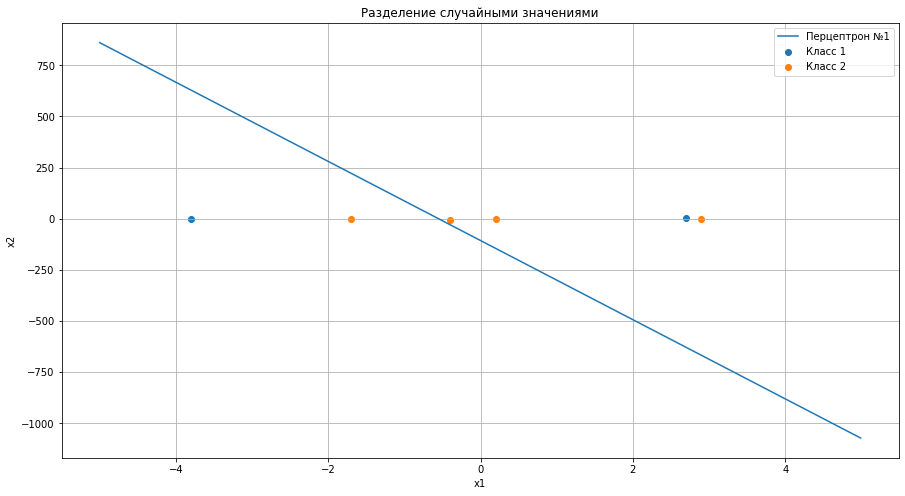

In [6]:
plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(P.T[T.ravel() == 0].T[0], P.T[T.ravel() == 0].T[1], label="Класс 1")
plt.scatter(P.T[T.ravel() == 1].T[0], P.T[T.ravel() == 1].T[1], label="Класс 2")
plt.title("Разделение случайными значениями")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()
plt.legend()

Обучим модель на 50 эпох:

In [7]:
model.set_steps(50)
model.set_early_stop(True)
model.fit(P, T)

  2%|▏         | 1/50 [00:00<00:00, 1266.01it/s]


Результат обучения:

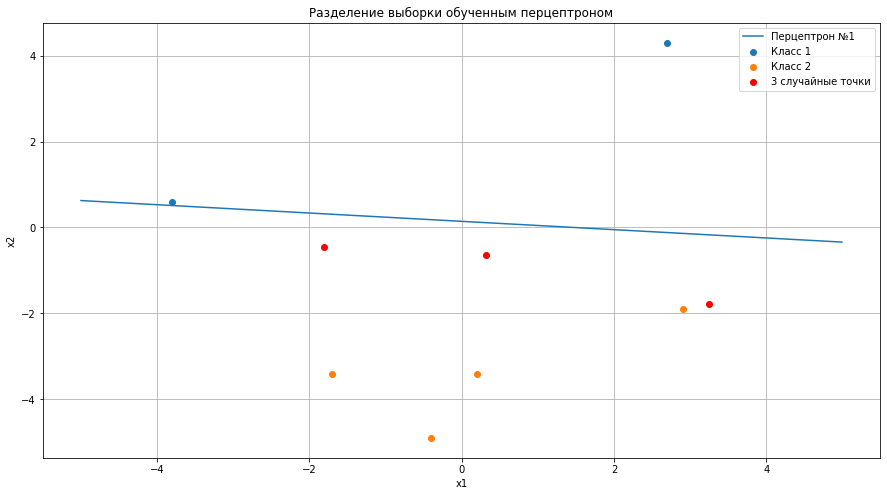

In [8]:
plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(P.T[T.ravel() == 0].T[0], P.T[T.ravel() == 0].T[1], label="Класс 1")
plt.scatter(P.T[T.ravel() == 1].T[0], P.T[T.ravel() == 1].T[1], label="Класс 2")
x = np.random.randint(-5, 4, 3) + np.random.random(3)
y = np.random.randint(-5, 4, 3) + np.random.random(3)
plt.scatter(x, y, color="red", label="3 случайные точки")
plt.xlabel("x1")
plt.ylabel("x2")

plt.title("Разделение выборки обученным перцептроном")
plt.grid()
plt.legend()

In [9]:
test = np.append(x.reshape(1, 3), y.reshape(1, 3), axis=0)
print("Test Data:")
print(test)
print("Predict:")
print(model.predict_classes(test))

Test Data:
[[ 0.32279564 -1.80453877  3.24492738]
 [-0.63238154 -0.4657158  -1.79242583]]
Predict:
[[1. 1. 1.]]


*Выход* модели на тренировочных данных:

In [10]:
model.predict(P) ## result of net func

array([[-1051.93234527,   -21.39283768,  1209.6902827 ,   882.52363172,
          419.48976568,   838.7697828 ]])

Полученные классы:

In [11]:
model.predict_classes(P)

array([[0., 0., 1., 1., 1., 1.]])

$MAE = \displaystyle\frac{\sum\limits_{i = 1}^{N}|t_i - a_i|}{N}$

In [12]:
model.score(P, T)

736.299774308469

Коэффиценты и смещения:

In [13]:
print("Веса:")
print(model.weights())
print("Смещения:")
print(model.bias())

Веса:
[[ -23.02834153]
 [-238.06899665]]
Смещения:
[33.94086248]


***Задание №2***

Сделаем выборку неразделимой:

In [14]:
P = np.append(P, np.array([[0.2], [3.4]]), axis=1)
T = np.append(T, np.array([[1]]), axis=1)

Как видим обучение прошло все шаги:

In [15]:
model = RosenblattLayer(50, True)
model.fit(P, T)

100%|██████████| 50/50 [00:00<00:00, 5187.25it/s]


Резултат обучения:

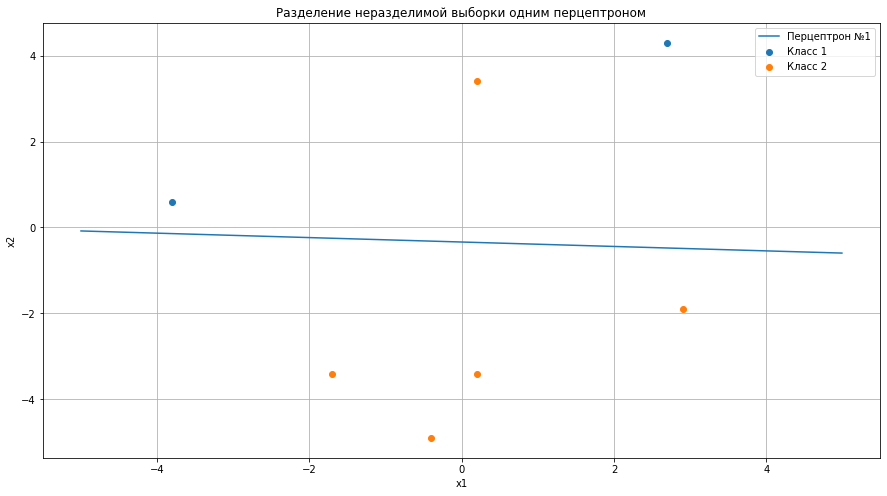

In [16]:
plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(P.T[T.ravel() == 0].T[0], P.T[T.ravel() == 0].T[1], label="Класс 1")
plt.scatter(P.T[T.ravel() == 1].T[0], P.T[T.ravel() == 1].T[1], label="Класс 2")
plt.xlabel("x1")
plt.ylabel("x2")

plt.title("Разделение неразделимой выборки одним перцептроном")
plt.grid()
plt.legend()

Как видим, модель допускает ошибки:

In [17]:
model.predict_classes(P) == T

array([[False, False, False, False, False, False,  True]])

***Задание №3***

Данные:

In [24]:
P = np.array([
    [-1.5, 4.6, 4.7, 1.6, 1.7, 1.2, -4.9, 4.7],
    [-0.6, -4.6, -3.2, 0.8, -1.4, 3.1, -4.2, 1.5]
])

T = np.array([
    [0, 0, 0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 0, 0, 1, 1]
])

Модель и ее структура:

In [25]:
model = RosenblattLayer(0).fit(P, T)
print(model.display())

0it [00:00, ?it/s]

 Input(n,2)  -->  Rosenblat Perceptrons(2)  -->  Output(n, 2)


In [26]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

model.set_steps(50)
model.set_early_stop(True)
model.fit(P, T)

100%|██████████| 50/50 [00:00<00:00, 5056.91it/s]


Посмотрим на разделение:

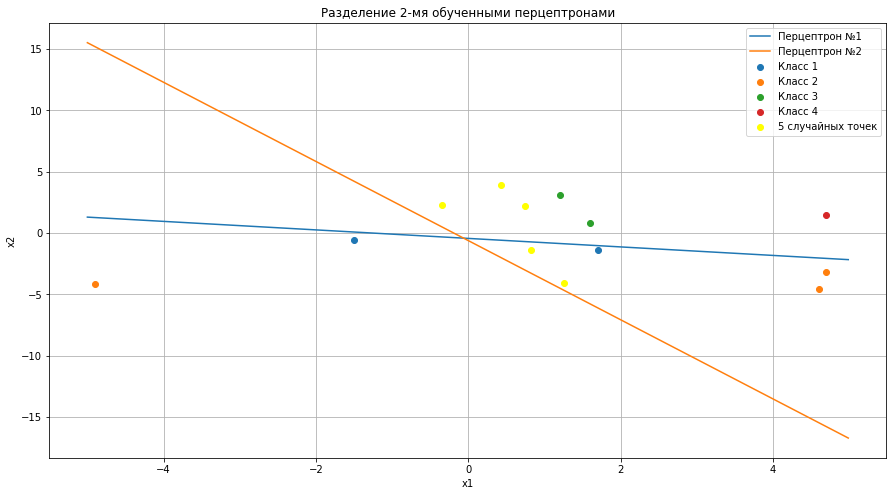

In [27]:
plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(
    P.T[(T[0] == 0) & (T[1] == 0)].T[0], 
    P.T[(T[0] == 0) & (T[1] == 0)].T[1], 
    label="Класс 1"
)
plt.scatter(
    P.T[(T[0] == 0) & (T[1] == 1)].T[0], 
    P.T[(T[0] == 0) & (T[1] == 1)].T[1], 
    label="Класс 2"
)
plt.scatter(
    P.T[(T[0] == 1) & (T[1] == 0)].T[0], 
    P.T[(T[0] == 1) & (T[1] == 0)].T[1], 
    label="Класс 3"
)
plt.scatter(
    P.T[(T[0] == 1) & (T[1] == 1)].T[0], 
    P.T[(T[0] == 1) & (T[1] == 1)].T[1], 
    label="Класс 4"
)

x = np.random.randint(-5, 4, 5) + np.random.random(5)
y = np.random.randint(-5, 4, 5) + np.random.random(5)

plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(x, y, color="yellow", label="5 случайных точек")

plt.title("Разделение 2-мя обученными перцептронами")
plt.grid()
plt.legend()

In [28]:
test = np.append(x.reshape(1, 5), y.reshape(1, 5), axis=0)
print("Test Data:")
print(test)
print("Predict:")
print(model.predict_classes(test))

Test Data:
[[ 0.43262775 -0.34340912  0.7484183   1.26079776  0.82410727]
 [ 3.88910826  2.26368772  2.17143204 -4.06897181 -1.37720121]]
Predict:
[[1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1.]]


In [29]:
print("Веса:")
print(model.weights())
print("Смещения:")
print(model.bias())

Веса:
[[6.78928959e+00 7.00305513e+91]
 [1.95760726e+01 2.17117716e+91]]
Смещения:
[8.67319022e+00 1.34449309e+91]
